In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from wordcloud import WordCloud
import nltk
import csv
from nltk.sentiment.vader import SentimentIntensityAnalyzer


In [162]:
# Define the states and the transitions/actions
all_state = {
    'Current state': ['0', '1', '4','5', '0','2','6','0', '3','7', '8'],
    'Input/Event': ['user text receive', 'destination receive', 'date receive','issue resolved','user text receive', 'date receive', 'issue resolved', 'user text receive', 'cancellation reason receive', 'issue resolved', 'issue resolved'],
    'Next state': ['1', '4', '5','close', '2','6', 'close', '3', '7/8', 'close','close'],
    'condition/Model': ['prediction model','-', '-', '-','prediction model', '-', '-','prediction model','-','healt issue','other issue',]}
df_all_state = pd.DataFrame(data=all_state)

print(df_all_state)



   Current state                  Input/Event Next state   condition/Model
0              0            user text receive          1  prediction model
1              1          destination receive          4                 -
2              4                 date receive          5                 -
3              5               issue resolved      close                 -
4              0            user text receive          2  prediction model
5              2                 date receive          6                 -
6              6               issue resolved      close                 -
7              0            user text receive          3  prediction model
8              3  cancellation reason receive        7/8                 -
9              7               issue resolved      close       healt issue
10             8               issue resolved      close       other issue


# An explanation of the model, a file with the states diagram is also attached to the project in the 'zip' file. 
State 0 is our starting state. From it, you can reach 3 different state. 1 - Hotel reservation 2 - postpone of the reservation. 3- Cancel the hotel
From mode 1 of booking a hotel: the user asked a follow-up question about the location, and the chatbot changes to state 4 of choosing the hotel destination, then the chat asks for the dates of stay and go to state 5, after the user answers the conversion end.
From mode 2: the user asked a follow-up question about the new dates he is interested in. After the chatbot receiving the dates from the customer its move to state 6, the chat will end.
From mode 3 of cancel the hotel: the user asked a follow-up question about the reason of cancellation, the chat move to an intermediate state where it checks the reason for the cancellation - if it health issue, we'll move to mode 7, and if there's another reason, we'll move to mode 8. After that, we'll end the conversion

In [221]:
# all the data - (Question , Label )
# sentiment : negative = neg, neutral = neu, positive = pos
row_data = [
    ("Can you help me book a hotel room for my upcoming trip?", "reservation"),
    ("I'd like to reserve a hotel room for my stay next weekend, please.","reservation"),
    ("What are the available options for booking a hotel room", "reservation"),
    ("I'm looking to book a hotel room for a business trip next month.", "reservation"),
    ("Can you assist me in booking a hotel near the airport for my overnight stay?", "reservation"),
    ("I'm eager to book a hotel room with a balcony for my stay.", "reservation"),
    ("book a hotel", "reservation"),
    ("I've encountered issues with the booking process. can you fix it?", "reservation"),
    ("book a room", "reservation"),
    ("make a reservation", "reservation"),
    ("I'm excited to book a hotel room for my upcoming vacation!", "reservation"),
    ("The hotel reservation is for my anniversary celebration, and I want it to be special.", "reservation"),
    ("I am excited to book a hotel room for my much-needed getaway.", "reservation"),
    ("I'm frustrated with the lack of availability for my preferred dates. What are my options?", "reservation"),
    ("I need to book a hotel room for a conference I'm attending next month.", "reservation"),
    ("Can you help me find a hotel with a gym and pool facilities?", "reservation"),
    ("I'm considering booking a hotel room for a spontaneous weekend trip.", "reservation"),
    ("I'm looking to book a hotel room with a kitchenette for added convenience.", "reservation"),
    ("I'm interested in booking a hotel room with a balcony overlooking the city.", "reservation"),
    ("The hotel reservation is for my family reunion, so I need accommodations for multiple guests.", "reservation"),
    ("I need to book a hotel room for my business trip next week.", "reservation"),
    ("I need a hotel room for a short stay during my layover.", "reservation"),
    ("I'm searching for a hotel room with easy access to public transportation.", "reservation"),
    ("I'm considering booking a hotel room for my weekend shopping trip.", "reservation"),
    ("I'm interested in booking a hotel room with a spa for a relaxing getaway.", "reservation"),
    ("I'm planning to book a hotel room for my graduation trip with friends.", "reservation"),
    ("I'm planning a business trip. What options do you have for booking a hotel with meeting facilities?", "reservation"),
    ("I need to book a hotel room with wheelchair-accessible facilities. Can you assist me with that?", "reservation"),
    ("I'm interested in booking a suite for a special occasion.", "reservation"),
    ("Do you offer any all-inclusive hotel packages for bookings?", "reservation"),
    ("I'm looking forward to staying at the hotel, I want to book a large enough room.", "reservation"),
    ("I need a hotel room for a short stay during my layover.", "reservation"),
    ("can i book an hotel reservation in london for a week", "reservation"),

    ("Unfortunately, I need to postpone my vacation. Can we reschedule my hotel booking?", "postpone"),
    ("I've encountered unexpected circumstances and need to postpone my vacation. How can I proceed with rescheduling?", "postpone"),
    ("Due to a scheduling conflict, I won't be abel to make it to me vacation, Can we adjust the dates?", "postpone"),
    ("I've had a change in plans and need to delay my vacation. how can I do it?", "postpone"),
    ("Thank you for your understanding. I'm grateful for the support in changing my hotel reservation.", "postpone"),
    ("I appreciate your assistance in rescheduling my trip. Can you help finalize the new dates?", "postpone"),
    ("I need to change the duration of my booking", "postpone"),
    ("I need to postpone the duration of my booking", "postpone"),
    ("I need to postpone the duration of my hotel booking", "postpone"),
    ("Is it possible to postpone my hotel booking to a later date", "postpone"),
    ("I need to change the dates of my hotel booking", "postpone"),
    ("I need to change the dates of my hotel booking", "postpone"),
    ("Due to a scheduling conflict, I need to postpone my vacation. Can we adjust the dates?", "postpone"),
    ("Your flexibility in helping me adjust my travel plans is greatly appreciated. Thank you!", "postpone"),
    ("I've had a change in plans and need to delay my trip. Can you help me reschedule?", "postpone"),
    ("I'm feeling stressed about needing to reschedule my vacation last minute. Can you help ease the process?", "postpone"),
    ("I need to change the duration of my vacation, and there for have to reschedule my booking", "postpone"),
    ("My travel plans have been disrupted due to unforeseen circumstances. How can I navigate this situation?", "postpone"),
    ("I need to reschedule my hotel booking to a later date. How can I proceed with this change?", "postpone"),
    ("I want to reschedule my hotel reservation because my plans change.", "postpone"),
    ("I'm anxious about changing my hotel reservation dates. Can you clarify the options available?", "postpone"),
    ("Can I adjust the dates of my hotel reservation after it's been confirmed?", "postpone"),
    ("Can I reschedule my hotel reservation due to a change in my travel itinerary?", "postpone"),
    ("Due to unforeseen circumstances, I won't be able to travel as planned. How can I change my reservation dates?", "postpone"),
    ("Due to unforeseen circumstances, I need to reschedule my trip. How can I update my hotel reservation?", "postpone"),
    ("I need to adjust my travel dates. How can I go about rescheduling my hotel stay?", "postpone"),
    ("Due to a family emergency, I need to delay my travel plans. Can you assist me with changing my reservation dates?", "postpone"),
    ("Is there a fee for postponing my hotel reservation?", "postpone"),
    ("Is it possible to postpone my hotel reservation to a later date", "postpone"),
    ("Is it possible to delly my hotel reservation to a later date", "postpone"),
    ("I need to change the dates of my vacation, how can I do it?", "postpone"),
    ("I need to change the dates of my vacation", "postpone"),
    ("I need to reschedule my hotel booking due to flight changes. Can you help with adjusting the dates?", "postpone"),
    ("I was wondering if i can change my hotel reservation", "postpone"),

    ("I need to cancel my vacation due to personal reasons. Can you assist me with that", "cancel"),
    ("I need to cancel my hotel reservation. Can you assist with the process?", "cancel"),
    ("Unfortunately, I won't be able to go on my trip and I want to cancel?", "cancel"),
    ("I want to cancel my booking.", "cancel"),
    ("I need to cancel my vacation. What are the steps for cancellation?", "cancel"),
    ("please cancel the room I order I your hotel", "cancel"),
    ("I'm unsure about the why I need to cancel my hotel reservation. Can you provide guidance on the options?", "cancel"),
    ("I won't be able to go on my trip. How can I cancel my hotel booking", "cancel"),
    ("The hotel room I booked doesn't meet my expectations.  I want to cancel", "reservation"),
    ("I'm upset that I have to cancel my vacation due to personal reasons. Can you guide me through the cancellation process?", "cancel"),
    ("Unfortunately, I won't be able to go on my trip and I'm disappointed about canceling my hotel reservation.", "cancel"),
    ("Unfortunately, I won't be able to go on my trip. How can I cancel my hotel reservation", "cancel"),
    ("I'm feeling regretful about canceling my vacation. What are the next steps?", "cancel"),
    ("Is there a penalty for canceling my hotel reservation close to the check-in date?", "cancel"),
    ("I'm considering canceling my vacation. How do I proceed with canceling the hotel reservation?", "cancel"),
    ("I need assistance with canceling my hotel booking due to unforeseen circumstances. Can you help?", "cancel"),
    ("I'm grateful for the opportunity to cancel my hotel reservation and receive a refund for my canceled trip.", "cancel"),
    ("I'm frustrated with the cancellation process. Is there any way you can help me?", "cancel"),
    ("please cancel my hotel booking", "cancel"),
    ("cancel booking", "cancel")
]

In [164]:
# use pandas to create DF
data = pd.DataFrame(row_data, columns=["text", "label"])

# create mapping to change the label to numeric 
label_to_numeric = {"reservation": 1, "postpone": 2, "cancel": 3}
print(data.head())
print(data.describe())
print(data['label'].unique())
print(data.shape)

                                                text        label
0  Can you help me book a hotel room for my upcom...  reservation
1  I'd like to reserve a hotel room for my stay n...  reservation
2  What are the available options for booking a h...  reservation
3  I'm looking to book a hotel room for a busines...  reservation
4  Can you assist me in booking a hotel near the ...  reservation
                                                  text        label
count                                               87           87
unique                                              85            3
top     I need to change the dates of my hotel booking  reservation
freq                                                 2           34
['reservation' 'postpone' 'cancel']
(87, 2)


In [165]:
# create a row to the label numeric value
data['label_num'] = data['label'].map(label_to_numeric)
# check if there aren't any Null
print(data.info())
# tokenization
# split the string into a single word that will be our tokens
data['text_token'] = data['text'].apply(lambda x: x.split())

# Subtract all numbers and signs that are not words
data['text_token'] = data['text_token'].apply(lambda x: [word for word in x if word.isalpha()])
# unite all the words in a line into a single string
data['text_token'] = data['text_token'].apply(lambda x: " ".join(x))



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       87 non-null     object
 1   label      87 non-null     object
 2   label_num  87 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 2.2+ KB
None


### EDA

In [166]:
data.shape

(87, 4)

In [167]:
data.describe()

,label_num
count,87.000000
mean,1.827586
std,0.765641
min,1.000000
25%,1.000000
50%,2.000000
75%,2.000000
max,3.000000


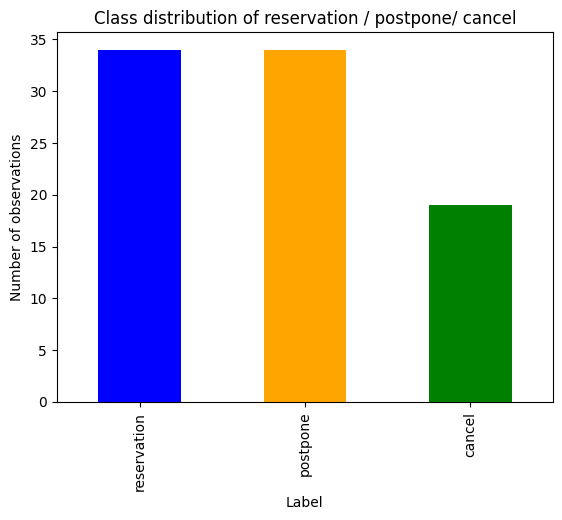

In [168]:
# Check the class distribution for each label - spam/ham
data['label'].value_counts().plot(kind='bar', color=['blue', 'orange', 'green'])
plt.title('Class distribution of reservation / postpone/ cancel')
plt.ylabel('Number of observations')
plt.xlabel('Label')
plt.show()


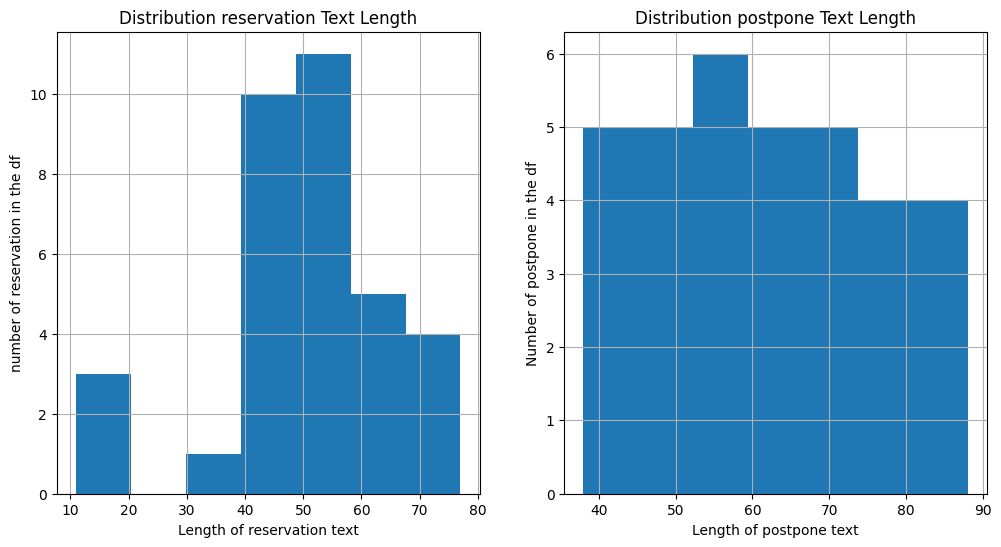

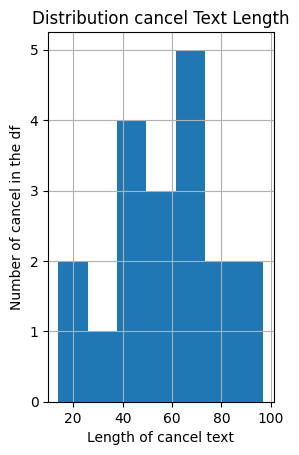

In [169]:
# check if there are different length between reservation / postpone/ cancel
reservation_len = data[data.label== 'reservation']['text_token'].apply(len)
postpone_len = data[data.label== 'postpone']['text_token'].apply(len)
cancel_len = data[data.label== 'cancel']['text_token'].apply(len)

# Plot histograms of text lengths
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
reservation_len.hist(bins=7)
plt.title('Distribution reservation Text Length')
plt.xlabel('Length of reservation text')
plt.ylabel('number of reservation in the df')

plt.subplot(1, 2, 2)
postpone_len.hist(bins=7)
plt.title('Distribution postpone Text Length')
plt.xlabel('Length of postpone text')
plt.ylabel('Number of postpone in the df')
plt.show()

plt.subplot(1, 2, 2)
cancel_len.hist(bins=7)
plt.title('Distribution cancel Text Length')
plt.xlabel('Length of cancel text')
plt.ylabel('Number of cancel in the df')
plt.show()

check the different words in each label

Features with lowest tfidf:
['for' 'the' 'booking' 'my' 'you' 'to' 'is' 'can' 'lack' 'frustrated']

Features with highest tfidf: 
['book' 'make' 'room' 'reservation' 'am' 'eager' 'upcoming' 'excited'
 'spontaneous' 'hotel']


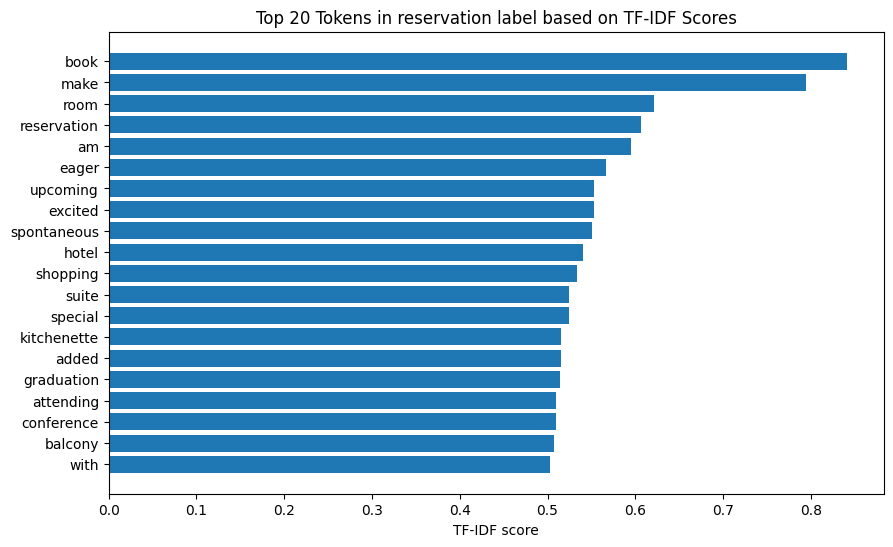

In [170]:
# reservation 
count = TfidfVectorizer()
X_reservation = data[data['label'] == 'reservation']['text_token']
X_reservation_tfidf = count.fit_transform(X_reservation)
# Extract feature names and tf-idf scores
feature_names = np.array(count.get_feature_names_out())
sorted_count_reservation = X_reservation_tfidf.max(0).toarray()[0].argsort()

# Print the EDA of tokens - The 10 most common words and the 10 most uncommon words
print("Features with lowest tfidf:\n{}\n".format(feature_names[sorted_count_reservation[:10]]))
print("Features with highest tfidf: \n{}".format(feature_names[sorted_count_reservation[:-11:-1]]))

# Plotting the top tokens
top_n = 20
top_tokens = feature_names[sorted_count_reservation[:-top_n-1:-1]]
top_scores = X_reservation_tfidf.max(0).toarray()[0][sorted_count_reservation[:-top_n-1:-1]]

# defining the graph 
plt.figure(figsize=(10, 6))
plt.barh(top_tokens, top_scores)
plt.xlabel('TF-IDF score')
plt.title('Top {} Tokens in reservation label based on TF-IDF Scores'.format(top_n))
plt.gca().invert_yaxis()
plt.show()


Features with lowest tfidf:
['can' 'you' 'hotel' 'need' 'your' 'the' 'thank' 'me' 'help' 'reservation']

Features with highest tfidf: 
['for' 'vacation' 'we' 'duration' 'do' 'because' 'want' 'update' 'if'
 'was']


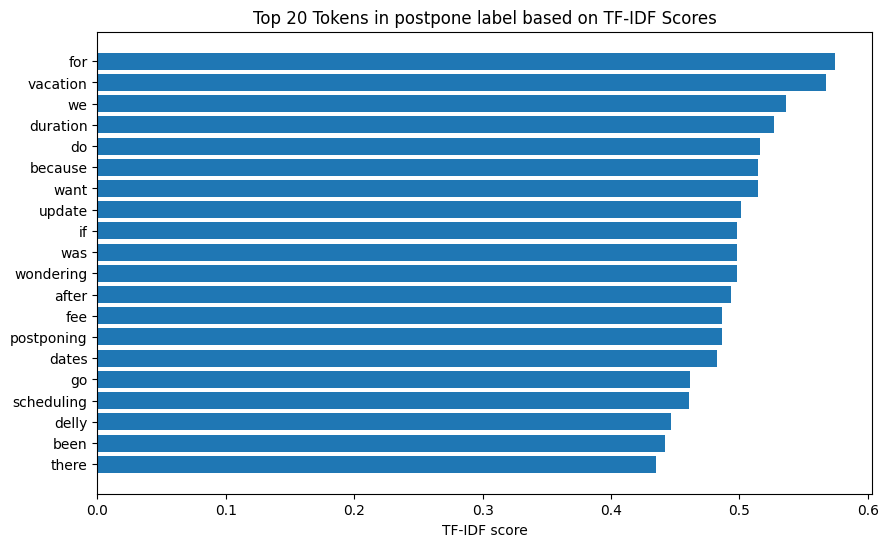

In [171]:
# postpone 
X_postpone = data[data['label'] == 'postpone']['text_token']
X_postpone_tfidf = count.fit_transform(X_postpone)
# Extract feature names and tf-idf scores
feature_names = np.array(count.get_feature_names_out())
sorted_count_postpone = X_postpone_tfidf.max(0).toarray()[0].argsort()

# Print the EDA of tokens - The 10 most common words and the 10 most uncommon words
print("Features with lowest tfidf:\n{}\n".format(feature_names[sorted_count_postpone[:10]]))
print("Features with highest tfidf: \n{}".format(feature_names[sorted_count_postpone[:-11:-1]]))

# Plotting the top tokens
top_n = 20
top_tokens_postpone = feature_names[sorted_count_postpone[:-top_n-1:-1]]
top_scores_postpone = X_postpone_tfidf.max(0).toarray()[0][sorted_count_postpone[:-top_n-1:-1]]

# defining the graph 
plt.figure(figsize=(10, 6))
plt.barh(top_tokens_postpone, top_scores_postpone)
plt.xlabel('TF-IDF score')
plt.title('Top {} Tokens in postpone label based on TF-IDF Scores'.format(top_n))
plt.gca().invert_yaxis()
plt.show()


Features with lowest tfidf:
['can' 'have' 'upset' 'through' 'guide' 'on' 'canceled' 'grateful'
 'opportunity' 'refund']

Features with highest tfidf: 
['booking' 'want' 'please' 'canceling' 'cancel' 'for' 'assist' 'steps'
 'order' 'room']


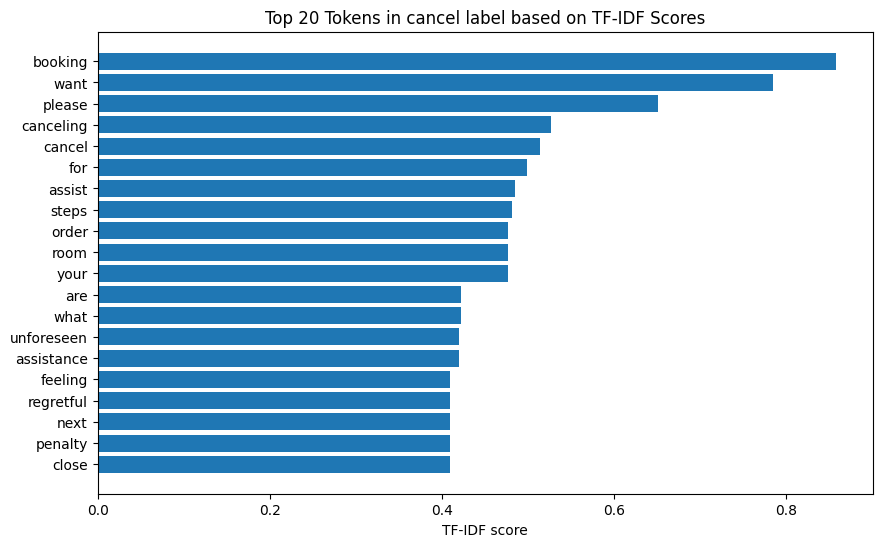

In [172]:
# cancel
X_cancel = data[data['label'] == 'cancel']['text_token']
X_cancel_tfidf = count.fit_transform(X_cancel)
# Extract feature names and tf-idf scores
feature_names_cancel = np.array(count.get_feature_names_out())
sorted_count_cancel = X_cancel_tfidf.max(0).toarray()[0].argsort()

# Print the EDA of tokens - The 10 most common words and the 10 most uncommon words
print("Features with lowest tfidf:\n{}\n".format(feature_names_cancel[sorted_count_cancel[:10]]))
print("Features with highest tfidf: \n{}".format(feature_names_cancel[sorted_count_cancel[:-11:-1]]))

#  Plotting the top tokens
top_n = 20
top_tokens_cancel = feature_names_cancel[sorted_count_cancel[:-top_n-1:-1]]
top_scores_cancel = X_cancel_tfidf.max(0).toarray()[0][sorted_count_cancel[:-top_n-1:-1]]

# defining the graph 
plt.figure(figsize=(10, 6))
plt.barh(top_tokens_cancel, top_scores_cancel)
plt.xlabel('TF-IDF score')
plt.title('Top {} Tokens in cancel label based on TF-IDF Scores'.format(top_n))
plt.gca().invert_yaxis()
plt.show()


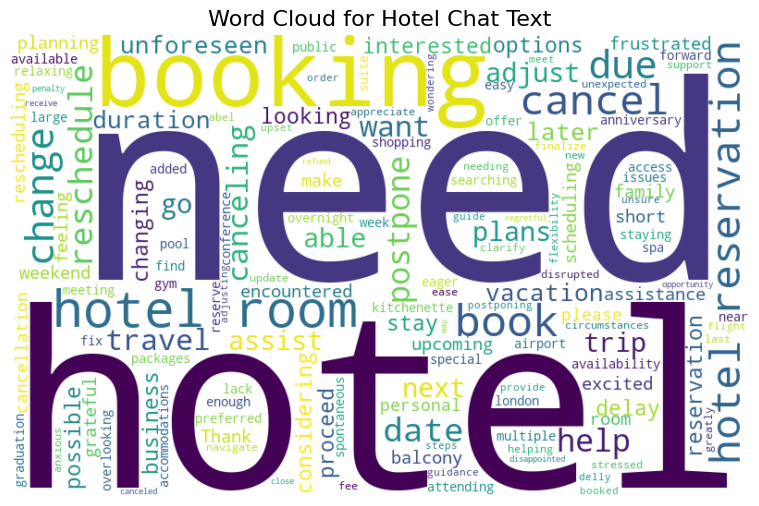

In [173]:
# create a word cloud to see what is the common word 
all_text = ' '.join(data['text_token'])

wordcloud = WordCloud(width=800, height=500, background_color='white').generate(all_text)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Hotel Chat Text', fontsize=16)
plt.axis('off')
plt.show()

In [174]:
# create X and y with the relevant columns 
X = data['text_token']
y = data['label_num']

# split the data into test and train
X_train, X_test, y_train, y_test = (
    train_test_split(X, y,
                     test_size=0.2, random_state=34))
print(X_train)
print(y_train)

56    Due to unforeseen I be able to travel as How c...
55    Can I reschedule my hotel reservation due to a...
12             I am excited to book a hotel room for my
49    I need to change the duration of my and there ...
0     Can you help me book a hotel room for my upcoming
                            ...                        
69             I be able to go on my trip and I want to
35    Due to a scheduling I be abel to make it to me...
68    I need to cancel my hotel Can you assist with the
85                       please cancel my hotel booking
33     I need to postpone my Can we reschedule my hotel
Name: text_token, Length: 69, dtype: object
56    2
55    2
12    1
49    2
0     1
     ..
69    3
35    2
68    3
85    3
33    2
Name: label_num, Length: 69, dtype: int64


In [175]:
# train the model - creating a pipline
pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1,4), stop_words="english")),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier(max_depth=25, n_estimators=40, random_state=12))
])

# fit pipeline
pipeline.fit(X_train, y_train)


Pipeline(steps=[('vect',
                 CountVectorizer(ngram_range=(1, 4), stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 RandomForestClassifier(max_depth=25, n_estimators=40,
                                        random_state=12))])

check the Ngram - create a matrix that will show all the tokens (from 1 to 4 word in a row) in the data and if it in the text it writes '1' else it '0'
the get ngrams return and print the most common tokens 

In [176]:
def get_matrix(text_df_input, model_input):
    matrix = model_input.fit_transform(text_df_input).toarray()
    return pd.DataFrame(data = matrix, columns = model_input.get_feature_names_out())


def get_ngrams(text, ngram_from=2, ngram_to=2, n=None, max_features=20000):

    vec = CountVectorizer(ngram_range = (ngram_from, ngram_to),
                          max_features = max_features).fit(text)
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis = 0)
    words_freq = [(word, sum_words[0, i]) for word, i in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

    return words_freq[:n]

In [177]:
ngram_matrix = get_matrix(data['text_token'],CountVectorizer(ngram_range=(1,4), stop_words="english") )
ngram_matrix.T.head(10)

,0,1,2,3,4,5,6,7,8,9,...,77,78,79,80,81,82,83,84,85,86
abel,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abel make,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abel make adjust,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
able,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
able cancel,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
able cancel hotel,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
able cancel hotel booking,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
able cancel hotel reservation,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
able travel,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
able travel change,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [178]:
unigrams = get_ngrams(data['text_token'], ngram_from=1, ngram_to=3,n=100)
unigrams_df = pd.DataFrame(unigrams)
unigrams_df.columns=["Unigram", "Frequency"]
unigrams_df

,Unigram,Frequency
0,my,76
1,to,70
2,hotel,57
3,the,36
4,can,34
...,...,...
95,on,5
96,canceling my,5
97,are,4
98,what are,4


In [179]:
# check with the test set the quality of the model with prediction
pre_test = pipeline.predict(X_test)

accuracy_1 = accuracy_score(y_test, pre_test)
print(f"Accuracy: {accuracy_1: .3f}")

report = classification_report(y_test, pre_test)
print("Classification Report for X test:\n", report)
cm_test = confusion_matrix(y_test, pre_test)

Accuracy:  0.833
Classification Report for X test:
               precision    recall  f1-score   support

           1       0.83      0.71      0.77         7
           2       0.75      0.86      0.80         7
           3       1.00      1.00      1.00         4

    accuracy                           0.83        18
   macro avg       0.86      0.86      0.86        18
weighted avg       0.84      0.83      0.83        18


In [180]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to C:\Users\Adi
[nltk_data]     Blau\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [181]:
nlp = spacy.load("en_core_web_sm")
# Function to extract entities using spacy NER
def extract_entities(text1):
    text_proc2 = nlp(text1)
    entities = [(ent.text, ent.label_) for ent in text_proc2.ents]
    return entities

In [182]:
# function that take text and predict using the model we created
def predict(text):
    # Predict the intent 

    intent = pipeline.predict([text])[0]
    # Predicts probabilities for each intent
    probabilities = pipeline.predict_proba([text])[0]
    # Finds the maximum among predicted probabilities
    max_probability = max(probabilities)
    # Check if the maximum probability is below the confidence threshold
    if max_probability < 0.45:
    # Confidence below the threshold, intent will classify as -1 meaning 'other'
         intent = -1

    print("probabilities", probabilities)
    print("max_probability", max_probability)

    return intent
   

In [183]:
# Identify the writer's sentiment, convert a number to a word
def test_compound(c):
    if c > 0:
        return 'positive'
    if c == 0:
        return 'neutral'
    return 'negative'


In [184]:
# to extract the Sentiment 
def sentiment_analysis(text):
    # Create a SentimentIntensityAnalyzer object
    sid = SentimentIntensityAnalyzer()    # Sentiment analysis
    sentiment_scores = sid.polarity_scores(text)
    # Extract polarity score (-1 to 1)
    polarity = sentiment_scores['compound']
    comp_score= test_compound(polarity)

    return comp_score

In [228]:
def conversation_flow(initial_intent, current_state, user_input):
    global temp_state
    # If we are in intent of reservation
    if initial_intent == 1: 
        if current_state == 1:
            # Changing the current and next state to reservation in progress
            current_state = 4
            next_state = current_state
            return "Sure, I can help you book a hotel. What is your desired destination?", next_state
        elif current_state == 4:
            # Changing the current and next state to destination in progress
            current_state = 5
            next_state = current_state
            return "And on which dates would you like to book the hotel?", next_state
        elif current_state == 5:
            # Changing the current and next state to dates of staying in progress
            next_state = current_state
            return "Ok! Thank you, goodbye! Please write 'exit' for closing the chat bot", next_state
    # If we are in intent of change
    if initial_intent == 2: 
        if current_state == 2:
            current_state = 6
            # Changing the current and next state to change in progress
            next_state = current_state
            return "Sure, I can help you with changing your booking. What date would you like to change to?", next_state
        elif current_state == 6:
            # Changing the current and next state to dates change in progress
            next_state = current_state
            return "Ok! Thank you, goodbye! Please write 'exit' for closing the chat bot", next_state
    # If we are in intent of cancel
    if initial_intent == 3: 
        if current_state == 3:
            # Temp will be a waiting point to understand what is the reason of cancellation
            temp_state = 10
            next_state = temp_state
            return "Sure, I can help you with cancelling your booking. What is the reason for cancellation?", next_state
        elif temp_state == 10:
            health_keywords = ['health', 'medical', 'disease', 'symptom', 'medical condition', 'sick']
            text_lower = user_input.lower()
            # Checking if any of the entities have a type related to health
            for keyword in health_keywords:
                if keyword in text_lower:
                    # Changing the current and next state to health reason in progress
                    current_state =7
                    next_state = current_state
                    return "Ok! I'll give you a 50% discount on cancellation fee. Thank you, goodbye! Please write 'exit' for closing the chat bot", next_state
        
            # If the words from the "health_keywords" aren't in the text- changing the current and next state to other reason in progress
            current_state = 8
            next_state = current_state
            return "Ok! I'll give you a 20% discount on cancellation fee. Thank you, goodbye! Please write 'exit' for closing the chat bot", next_state

    else:
        # The state will be -1 if it was unable to identify the user's intent
        current_state = -1
        return "I was unable to identify the user's intent", current_state


In [186]:
# Main function to process user input and generate responses
def process_chat_input(user_input, current_state, initial_intent):
    response, next_state = conversation_flow(initial_intent, current_state, user_input)
    entities = extract_entities(user_input)
    polarity = sentiment_analysis(user_input)
    return response, initial_intent, next_state, entities, polarity, current_state


### Online chat

In [204]:
# the function that runs the online chat
def run_online_chatbot():
    current_state = 0
    user_input = input('What can I help you with?')
    # Update the initial intent value for the first interaction
    initial_intent = predict(user_input)
    if initial_intent == 1:
        current_state = 1
    if initial_intent == 2:
        current_state = 2
    if initial_intent == 3:
        current_state = 3
    i = 0
    while True:
        i += 1
        # the chat will end when the user write "exit"
        if str.lower(user_input) == 'exit' :
            return False
        if i > 1: # The chat shows the text below only from the second and subsequent interactions
            user_input = input('Your Response (write "exit" to end conversion):')
            
        print('user: ' + user_input)
        print("process chat input: ", process_chat_input(user_input, current_state, initial_intent))
        output, intent, next_state, entities,polarity, current_state = process_chat_input(user_input, current_state, initial_intent)
        # the chatbot end the conversion when it arrived at the last state - 5 or 6 or 7 or 8 , also in case the model doesn't identify the intent it returns '-1' and end chat
        if current_state == 5 or current_state== 6 or current_state == 7 or current_state== 8 or current_state == -1 :
            return False
        
        # update the state to the next one
        current_state = next_state
        # if the user didn't write anything the chatbot will continue offer help
        if output is None:
            print("Error")
            continue
        print('Chatbot:' + output)
 
        

# for the online chat: 
As a user, these are the answers you need to enter at each step :
if you book a hotel (example: "I want to book a hotel") -> enter destination (example: "New york") -> enter dates (example: "27-5-2024")

if you postpone (example " I want to change the date of my reservation")-> enter a new dates (example: "10-9-2024")

if you cancel (example " I want to cancel my holiday")-> enter the reason: health issue / something else (example: "my sister is getting married")

 "temp state = 10" is a temporary state until it understand from the user what is the reason for the cancellation, and then it moves accordingly to state 7 or 8

in process chat input, the output meaning is: 
(chat's answer, intent, next state, entities, polarity, current state)

In [227]:
# if you wish to run the On-line chat please run this cell
run_online_chatbot()

probabilities [0.125 0.225 0.65 ]
max_probability 0.65
user: cancel
process chat input:  ('Sure, I can help you with cancelling your booking. What is the reason for cancellation?', 3, 10, [], 'negative', 3)
Chatbot:Sure, I can help you with cancelling your booking. What is the reason for cancellation?
user: sick
sick keyword
process chat input:  ("Ok! I'll give you a 50% discount on cancellation fee. Thank you, goodbye! Please write 'exit' for closing the chat bot", 3, 7, [], 'negative', 10)
sick keyword
Chatbot:Ok! I'll give you a 50% discount on cancellation fee. Thank you, goodbye! Please write 'exit' for closing the chat bot
user: exit


TypeError: cannot unpack non-iterable NoneType object

# Offline

In [189]:
# read the file that contains the questions sent to the chat
def read_chat_input_file(file_path):
    data_offline = pd.read_csv(file_path, header=None, names=['text'])
    return data_offline

In [219]:
# the function that runs the offline chat
def run_offline_chatbot(file_path):
    current_state = 0
    df = read_chat_input_file(file_path)
    initial_intent = None

    # list that stores the responses and other information
    responses = []
    first = True
    
    for index, row in df.iterrows():
        
        # Update the initial intent value for the first interaction
        if first :
            initial_intent = predict(row['text'])
            if initial_intent == 1:
                current_state = 1
            if initial_intent == 2:
                current_state = 2
            if initial_intent == 3:
                current_state = 3
            first = False
        output, intent, next_state, entities, polarity, current_state = process_chat_input(row['text'], current_state, initial_intent)
        
        # Append the result to the DataFrame
        responses.append({
            'output': output,
            'intent': intent,
            'state': next_state,
            'entities': entities,
            'polarity': polarity
        })
        # Update the current state for the next iteration
        current_state = next_state

    responses_df = pd.DataFrame(responses, columns=['output','intent' ,'state','entities' ,'polarity'])
    # Write the DataFrame to a csv file
    file_responses = "Responses.csv"
    # Convert DF to a list of lists
    new_data = [responses_df.columns.tolist()]  # Add column names as first row
    new_data.extend(responses_df.values.tolist())  # Add data rows
    # Open CSV file in write mode
    with open(file_responses, 'w', newline='') as file:
        write = csv.writer(file)
        # write new data to the CSV file
        write.writerows(new_data)
    
    return responses_df

In [220]:
#if you wish to run the Off-line chat please run this cell
run_offline_chatbot('Questions.csv')

probabilities [0.75 0.05 0.2 ]
max_probability 0.75
Hello I want to book a hotel for my vacation
London
10 May
exit


,output,intent,state,entities,polarity
0,"Sure, I can help you book a hotel. What is you...",1,4,[],positive
1,And on which dates would you like to book the ...,1,5,"[(London, GPE)]",neutral
2,"Ok! Thank you, goodbye! Please write 'exit' fo...",1,5,"[(10 May, DATE)]",neutral
3,"Ok! Thank you, goodbye! Please write 'exit' fo...",1,5,[],neutral


# Test for the model

In [229]:
# a test to see that the model we build is working 
test_text = ["I want to change the data of the hotel"]
intent = pipeline.predict(test_text)  # Predict the label (returns an array)
predicted_label = intent[0]  # Get the predicted label from the array

# Convert the predicted label to an integer
predicted_label_as_int = int(predicted_label)
predicted_proba = pipeline.predict_proba(test_text)[0]
print(predicted_proba)
print(predicted_label_as_int)

[0.325      0.47142857 0.20357143]
2
